In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, concatenate
from keras.models import Model
import pandas as pd
import keras.backend as K
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU

%matplotlib inline

Using TensorFlow backend.


Import the mnist_reader function to easily load the data.

In [2]:
os.chdir('E:\\Desktop\\Deep Learning\\fashion-mnist\\utils')

%run -i mnist_reader

os.chdir('E:\\Desktop\\Deep Learning\\fashion-mnist')

Here the training data are loaded and split into train and validation sets. The class labels are also encoded from categorical format to one-hot.

In [3]:
from sklearn.preprocessing import OneHotEncoder

x_train, y_train = load_mnist('data/fashion', kind='train')

X_train, X_Validation, Y_Train, Y_Validation = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

X_Test, Y_Test = load_mnist('data/fashion', kind='t10k')

X_Train = X_train.reshape(X_train.shape[0],28,28,1)
X_Validation = X_Validation.reshape(X_Validation.shape[0],28,28,1)
X_Test = X_Test.reshape(X_Test.shape[0],28,28,1)

oh = OneHotEncoder(sparse = False)

Y_Train = oh.fit_transform(X=Y_Train.reshape(X_train.shape[0],1))
Y_Validation = oh.fit_transform(X=Y_Validation.reshape(X_Validation.shape[0],1))
Y_Test = oh.fit_transform(X=Y_Test.reshape(X_Test.shape[0],1))

E:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before t

The 10 different class labels are:

<ol>
<li>T-shirt/top </li>
<li>Trouser </li>
<li>Pullover </li>
<li>Dress </li>
<li>Coat </li>
<li>Sandal </li>
<li>Shirt </li>
<li>Sneaker </li>
<li>Bag </li> 
<li>Ankle boot </li>
</ol>

So lets build the network:

In [141]:
def Conv_Block(input_tensor, filt_num,dropout = 0.3,dilation_rate = 4):
    X1 = Conv2D(filt_num, (3, 3),padding = 'same')(input_tensor)
    X2 = Conv2D(filt_num, (5, 5),padding = 'same')(input_tensor)
    X3 = Conv2D(filt_num, (7, 7),padding = 'same')(input_tensor)
    X4 = Conv2D(filt_num, (5, 5),padding = 'same', dilation_rate = dilation_rate)(input_tensor)
    X = concatenate([X1,X2,X3,X4], axis = 3) 
    X = BatchNormalization(axis = -1)(X)
    X = LeakyReLU()(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(rate = dropout)(X)
    
    return X

def Dense_Layer(input_tensor, filt_num,dropout = 0.2):
    X = BatchNormalization(axis = -1)(input_tensor)
    X = Dense(filt_num)(X)
    X = LeakyReLU()(X)
    X = Dropout(rate = dropout)(X)
    
    return X

def Fashion_Recognizer(input_shape):
    """
    Implementation of the Fashion_Recognizer.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    
    X_input = Input(input_shape)


    X = Conv_Block(X_input, 32)
    
    X = Conv2D(64, (1, 1), name = 'conv_compine1', padding = 'same')(X)    
    X = Conv_Block(X, 64,dilation_rate = 3, dropout = 0.3)
    
    X = Conv2D(128, (1, 1), name = 'conv_compine2', padding = 'same')(X)    
    X = Conv_Block(X, 128,dilation_rate = 3, dropout = 0.3)
    
    X = Conv2D(256, (1, 1), name = 'conv_compine3', padding = 'same')(X)    
    X = Conv_Block(X, 128,dilation_rate = 3, dropout = 0.3)
   
    X = Flatten()(X)
    
    X = Dense_Layer(X, 256)
    X = Dense_Layer(X, 128)     
    
    X = Dense(10, activation='softmax', name='fc3')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Fachion Recognizer')
    
    return model

def test_acc(model_to_eval):
    TestLoss, TestAcc = model_to_eval.evaluate_generator(Test_Generator.flow(X_Test, Y_Test))

    print("Test Loss: ", np.round(TestLoss,2))
    print()
    print("Test Accuracy: ", str(100*np.round(TestAcc,4)), "%")
    
def val_acc(model_to_eval):
    ValLoss, ValAcc = model_to_eval.evaluate_generator(Valid_Generator.flow(X_Validation, Y_Validation))

    print("Validation Loss: ", np.round(ValLoss,2))
    print()
    print("Validation Accuracy: ", str(100*np.round(ValAcc,4)), "%")

In [79]:
model_sgd = Fashion_Recognizer((28,28,1))

model_sgd.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_413 (Conv2D)             (None, 28, 28, 32)   320         input_45[0][0]                   
__________________________________________________________________________________________________
conv2d_414 (Conv2D)             (None, 28, 28, 32)   832         input_45[0][0]                   
__________________________________________________________________________________________________
conv2d_415 (Conv2D)             (None, 28, 28, 32)   1600        input_45[0][0]                   
__________________________________________________________________________________________________
conv2d_416

Three different optimizers will be used in order to train the network. SGD, Rmsprop and adam. The one with the best performance will be kept. Three generators are also created to load the data and also rescale the pixel values from range (1, 255) to (1/255, 1).

### Stochastic Gradient Descent Optimizer

In [80]:
from keras.metrics import categorical_accuracy

model_sgd.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = [categorical_accuracy])

In [81]:
batch_size = 128

Train_Generator = ImageDataGenerator(
    rescale=1./255)

Valid_Generator = ImageDataGenerator(
    rescale=1./255)

Test_Generator = ImageDataGenerator(
    rescale=1./255)

Train_Generator.fit(X_Train)
Valid_Generator.fit(X_Validation)
Test_Generator.fit(X_Test)

history = model_sgd.fit_generator(  Train_Generator.flow(X_Train, Y_Train, batch_size=batch_size),
                                    epochs=8,
                                    validation_data = Valid_Generator.flow(X_Validation, Y_Validation), 
                                    shuffle=True)

Epoch 1/8
375/375 [==============================] - 41s 110ms/step - loss: 0.9459 - categorical_accuracy: 0.6615 - val_loss: 0.5892 - val_categorical_accuracy: 0.7784
Epoch 2/8
375/375 [==============================] - 35s 94ms/step - loss: 0.6310 - categorical_accuracy: 0.7685 - val_loss: 0.4990 - val_categorical_accuracy: 0.8161
Epoch 3/8
375/375 [==============================] - 35s 94ms/step - loss: 0.5471 - categorical_accuracy: 0.8002 - val_loss: 0.4555 - val_categorical_accuracy: 0.8315
Epoch 4/8
375/375 [==============================] - 35s 95ms/step - loss: 0.4882 - categorical_accuracy: 0.8213 - val_loss: 0.4169 - val_categorical_accuracy: 0.8497
Epoch 5/8
375/375 [==============================] - 36s 95ms/step - loss: 0.4552 - categorical_accuracy: 0.8351 - val_loss: 0.3773 - val_categorical_accuracy: 0.8609
Epoch 6/8
375/375 [==============================] - 36s 95ms/step - loss: 0.4230 - categorical_accuracy: 0.8468 - val_loss: 0.3685 - val_categorical_accuracy: 0.86

In [92]:
val_acc(model_sgd)

Validation Loss:  0.33

Validation Accuracy:  88.08 %


In [93]:
test_acc(model_sgd)

Test Loss:  0.35

Test Accuracy:  87.38 %


### Rmsprop Optimizer

In [142]:
model_rmsprop = Fashion_Recognizer((28,28,1))

model_rmsprop.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = [categorical_accuracy])

history_rmsprop = model_rmsprop.fit_generator(  Train_Generator.flow(X_Train, Y_Train, batch_size=batch_size),
                                    epochs=8,
                                    validation_data = Valid_Generator.flow(X_Validation, Y_Validation), 
                                    shuffle=True)

Epoch 1/8
375/375 [==============================] - 43s 116ms/step - loss: 0.5632 - categorical_accuracy: 0.7999 - val_loss: 0.4578 - val_categorical_accuracy: 0.8559
Epoch 2/8
375/375 [==============================] - 37s 99ms/step - loss: 0.3485 - categorical_accuracy: 0.8748 - val_loss: 0.3410 - val_categorical_accuracy: 0.8848
Epoch 3/8
375/375 [==============================] - 38s 101ms/step - loss: 0.2994 - categorical_accuracy: 0.8919 - val_loss: 0.3191 - val_categorical_accuracy: 0.8912
Epoch 4/8
375/375 [==============================] - 38s 100ms/step - loss: 0.2715 - categorical_accuracy: 0.9019 - val_loss: 0.2597 - val_categorical_accuracy: 0.9108
Epoch 5/8
375/375 [==============================] - 37s 100ms/step - loss: 0.2501 - categorical_accuracy: 0.9097 - val_loss: 0.2487 - val_categorical_accuracy: 0.9083
Epoch 6/8
375/375 [==============================] - 37s 99ms/step - loss: 0.2387 - categorical_accuracy: 0.9116 - val_loss: 0.2516 - val_categorical_accuracy: 0

In [143]:
val_acc(model_rmsprop)

Validation Loss:  0.23

Validation Accuracy:  91.78 %


In [144]:
test_acc(model_rmsprop)

Test Loss:  0.26

Test Accuracy:  90.85 %


### Adam Optimizer

In [89]:
model_adam = Fashion_Recognizer((28,28,1))

model_adam.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = [categorical_accuracy])

history_adam = model_adam.fit_generator(  Train_Generator.flow(X_Train, Y_Train, batch_size=batch_size),
                                    epochs=8,
                                    validation_data = Valid_Generator.flow(X_Validation, Y_Validation), 
                                    shuffle=True)

Epoch 1/8
375/375 [==============================] - 43s 115ms/step - loss: 0.5673 - categorical_accuracy: 0.7925 - val_loss: 0.3387 - val_categorical_accuracy: 0.8748
Epoch 2/8
375/375 [==============================] - 37s 99ms/step - loss: 0.3419 - categorical_accuracy: 0.8767 - val_loss: 0.3128 - val_categorical_accuracy: 0.8898
Epoch 3/8
375/375 [==============================] - 37s 100ms/step - loss: 0.2926 - categorical_accuracy: 0.8938 - val_loss: 0.3038 - val_categorical_accuracy: 0.8902
Epoch 4/8
375/375 [==============================] - 37s 100ms/step - loss: 0.2660 - categorical_accuracy: 0.9029 - val_loss: 0.2680 - val_categorical_accuracy: 0.9089
Epoch 5/8
375/375 [==============================] - 37s 100ms/step - loss: 0.2432 - categorical_accuracy: 0.9112 - val_loss: 0.2324 - val_categorical_accuracy: 0.9137
Epoch 6/8
375/375 [==============================] - 37s 99ms/step - loss: 0.2293 - categorical_accuracy: 0.9162 - val_loss: 0.2449 - val_categorical_accuracy: 0

In [98]:
val_acc(model_adam)

Validation Loss:  0.23

Validation Accuracy:  91.58 %


In [99]:
test_acc(model_adam)

Test Loss:  0.24

Test Accuracy:  91.06 %


Here, the two optimizers with the best performance, rmsprop and adam, will be trained on augmented data. The images will be edited in various ways in order to add noise to the training set and try to increase validation accuracy. The augmentation types are the following:

* Rotation up to 45 Degrees
* Horizontal Flip
* Vertical Flip
* Zoom up to 20%

In [100]:
Train_Generator_aug = ImageDataGenerator(
    rotation_range = 45,
    fill_mode = 'çonstant',
    cval = 0,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range=0.2,
    rescale=1./255)

Valid_Generator = ImageDataGenerator(
    rescale=1./255)

Test_Generator = ImageDataGenerator(
    rescale=1./255)

Train_Generator.fit(X_Train)
Valid_Generator.fit(X_Validation)
Test_Generator.fit(X_Test)


model_rmsprop_augmented = Fashion_Recognizer((28,28,1))

model_rmsprop_augmented.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = [categorical_accuracy])

history_rmsprop_augmented = model_rmsprop_augmented.fit_generator(Train_Generator.flow(X_Train, Y_Train, batch_size=batch_size),
                                    epochs=10,
                                    validation_data = Valid_Generator.flow(X_Validation, Y_Validation), 
                                    shuffle=True)

Epoch 1/10
375/375 [==============================] - 42s 113ms/step - loss: 0.5474 - categorical_accuracy: 0.8028 - val_loss: 0.4965 - val_categorical_accuracy: 0.8608
Epoch 2/10
375/375 [==============================] - 37s 98ms/step - loss: 0.3414 - categorical_accuracy: 0.8768 - val_loss: 0.2814 - val_categorical_accuracy: 0.9021
Epoch 3/10
375/375 [==============================] - 37s 98ms/step - loss: 0.2935 - categorical_accuracy: 0.8940 - val_loss: 0.2680 - val_categorical_accuracy: 0.9052
Epoch 4/10
375/375 [==============================] - 37s 98ms/step - loss: 0.2633 - categorical_accuracy: 0.9039 - val_loss: 0.3028 - val_categorical_accuracy: 0.8945
Epoch 5/10
375/375 [==============================] - 37s 98ms/step - loss: 0.2459 - categorical_accuracy: 0.9097 - val_loss: 0.2446 - val_categorical_accuracy: 0.9105
Epoch 6/10
375/375 [==============================] - 37s 98ms/step - loss: 0.2307 - categorical_accuracy: 0.9152 - val_loss: 0.2452 - val_categorical_accuracy

In [101]:
val_acc(model_rmsprop_augmented)

Validation Loss:  0.23

Validation Accuracy:  92.35 %


In [102]:
test_acc(model_rmsprop_augmented)

Test Loss:  0.25

Test Accuracy:  91.43 %


In [103]:
Train_Generator_aug = ImageDataGenerator(
    rotation_range = 45,
    fill_mode = 'çonstant',
    cval = 0,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range=0.2,
    rescale=1./255)

Valid_Generator = ImageDataGenerator(
    rescale=1./255)

Test_Generator = ImageDataGenerator(
    rescale=1./255)

Train_Generator.fit(X_Train)
Valid_Generator.fit(X_Validation)
Test_Generator.fit(X_Test)


model_adam_augmented = Fashion_Recognizer((28,28,1))

model_adam_augmented.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = [categorical_accuracy])

history_adam_augmented = model_adam_augmented.fit_generator(Train_Generator.flow(X_Train, Y_Train, batch_size=batch_size),
                                    epochs=10,
                                    validation_data = Valid_Generator.flow(X_Validation, Y_Validation), 
                                    shuffle=True)

Epoch 1/10
375/375 [==============================] - 44s 117ms/step - loss: 0.5514 - categorical_accuracy: 0.7992 - val_loss: 0.3941 - val_categorical_accuracy: 0.8620
Epoch 2/10
375/375 [==============================] - 37s 100ms/step - loss: 0.3419 - categorical_accuracy: 0.8769 - val_loss: 0.2862 - val_categorical_accuracy: 0.8941 - loss: 0.3618 - categ - ETA: 3s - loss: 0 - ETA: 
Epoch 3/10
375/375 [==============================] - 38s 101ms/step - loss: 0.2932 - categorical_accuracy: 0.8929 - val_loss: 0.2683 - val_categorical_accuracy: 0.9020orical_a
Epoch 4/10
375/375 [==============================] - 38s 100ms/step - loss: 0.2657 - categorical_accuracy: 0.9042 - val_loss: 0.2368 - val_categorical_accuracy: 0.9141
Epoch 5/10
375/375 [==============================] - 38s 100ms/step - loss: 0.2438 - categorical_accuracy: 0.9105 - val_loss: 0.2581 - val_categorical_accuracy: 0.9071catego
Epoch 6/10
375/375 [==============================] - 38s 100ms/step - loss: 0.2316 - cate

In [104]:
val_acc(model_adam_augmented)

Validation Loss:  0.24

Validation Accuracy:  91.88 %


In [105]:
test_acc(model_adam_augmented)

Test Loss:  0.26

Test Accuracy:  90.88000000000001 %


## Stochastic Gradient Descent Model Learning History

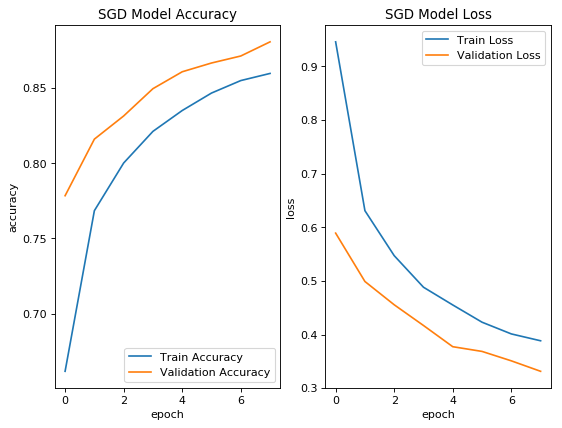

In [122]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('SGD Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy',
             'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SGD Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

## Rmsprop Model Learning History

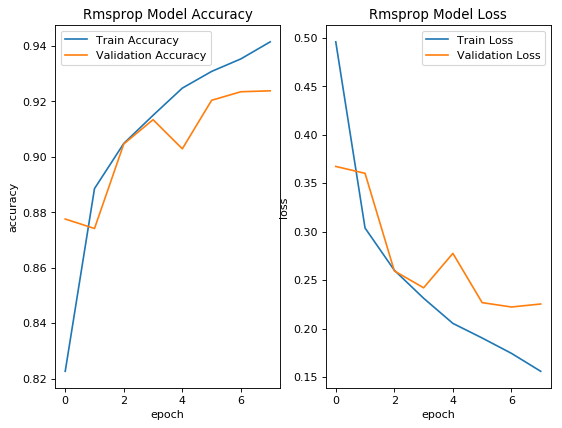

In [138]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(history_rmsprop.history['categorical_accuracy'])
plt.plot(history_rmsprop.history['val_categorical_accuracy'])
plt.title('Rmsprop Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy',
             'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history_rmsprop.history['loss'])
plt.plot(history_rmsprop.history['val_loss'])
plt.title('Rmsprop Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

## Adam Model Learning History

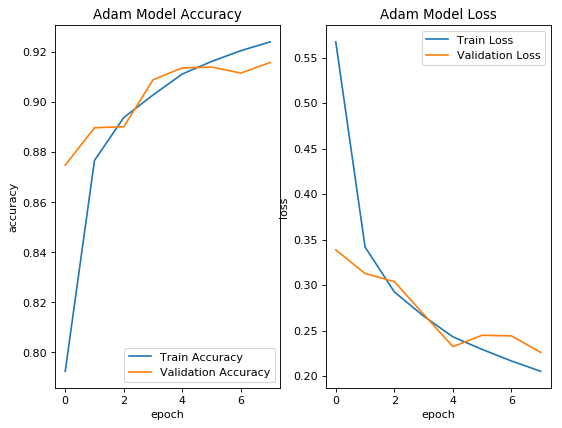

In [124]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(history_adam.history['categorical_accuracy'])
plt.plot(history_adam.history['val_categorical_accuracy'])
plt.title('Adam Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy',
             'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Adam Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

## Rmsprop Model Learning History with Augmented Data

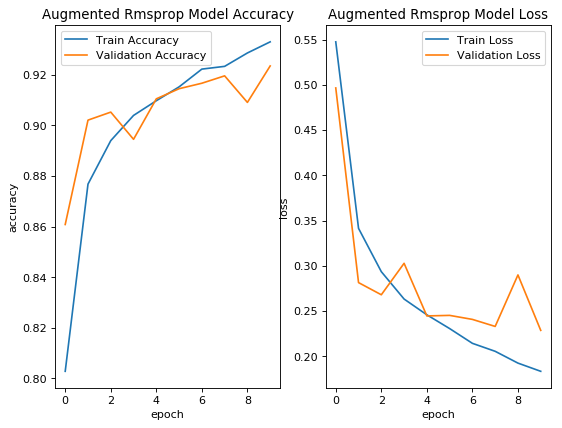

In [140]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(history_rmsprop_augmented.history['categorical_accuracy'])
plt.plot(history_rmsprop_augmented.history['val_categorical_accuracy'])
plt.title('Augmented Rmsprop Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy',
             'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history_rmsprop_augmented.history['loss'])
plt.plot(history_rmsprop_augmented.history['val_loss'])
plt.title('Augmented Rmsprop Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

## Adam Model Learning History with Augmented Data

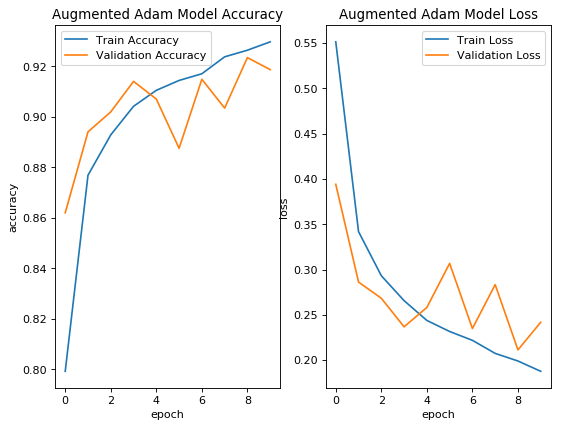

In [127]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(history_adam_augmented.history['categorical_accuracy'])
plt.plot(history_adam_augmented.history['val_categorical_accuracy'])
plt.title('Augmented Adam Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy',
             'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history_adam_augmented.history['loss'])
plt.plot(history_adam_augmented.history['val_loss'])
plt.title('Augmented Adam Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

In [130]:
from sklearn.metrics import confusion_matrix

predictions = model_rmsprop_augmented.predict(X_Test)
predicted = oh.inverse_transform(predictions).reshape((10000,))

true = oh.inverse_transform(Y_Test).reshape((10000,))

confusion_matrix(y_true = true, y_pred = predicted)

array([[436,   0,   1,   3,  15,   1, 457,   0,  87,   0],
       [  0, 949,   0,   1,   8,   0,  12,   0,  30,   0],
       [  4,   0, 400,   1, 156,   0, 385,   0,  54,   0],
       [  1,   2,   1, 543, 129,   0, 160,   0, 162,   2],
       [  0,   0,   5,   1, 878,   0,  92,   0,  24,   0],
       [  0,   0,   0,   0,   0, 976,   0,   0,  23,   1],
       [ 10,   0,   2,   2,  49,   0, 897,   0,  40,   0],
       [  0,   0,   0,   0,   1,  38,   1, 822, 133,   5],
       [  1,   0,   0,   0,   0,   0,   1,   0, 998,   0],
       [  0,   0,   0,   0,   0,  15,   2,   8, 117, 858]], dtype=int64)